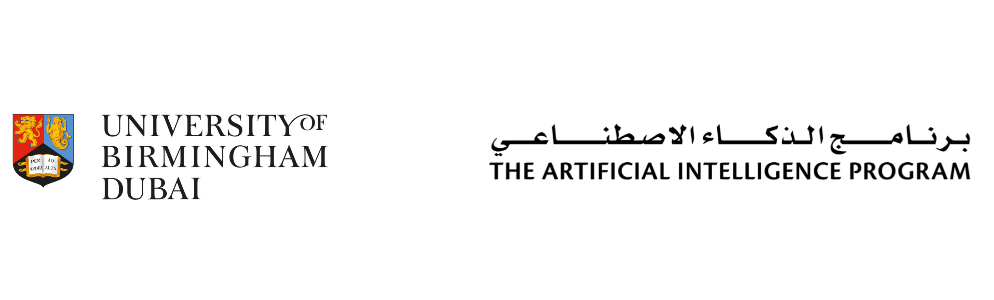


# Hands On: Reinforcement Learning


The CartPole environment from OpenAI Gym is a classic control problem used to benchmark reinforcement learning algorithms.

**Goal:** The goal is to balance a pole, which is attached by an un-actuated joint to a cart, for as long as possible.  The cart moves along a frictionless track.  The agent must apply a force to the cart (either pushing left or right) to keep the pole upright.


<img src="https://aleksandarhaber.com/wp-content/uploads/2023/01/sketch-1-1024x608.png" width="720">



**State:** The environment provides the following four state variables at each time step:

1. **Cart Position:** The horizontal position of the cart along the track.
2. **Cart Velocity:** The velocity of the cart.
3. **Pole Angle:** The angle of the pole with respect to the vertical.  This is the crucial variable; a large angle indicates an imminent fall.
4. **Pole Angular Velocity:** The rate at which the pole's angle is changing.


**Actions:**  The agent can take one of two discrete actions at each time step:

1. **Push cart to the left:** Apply a force to move the cart left.
2. **Push cart to the right:** Apply a force to move the cart right.


**Reward:** The agent receives a reward of +1 for every time step the pole remains upright.  The episode ends when:

* **Pole Angle Exceeds Threshold:** The pole tilts too far from the vertical.
* **Cart Position Exceeds Threshold:** The cart moves too far to the left or right.
* **Episode Length Limit:** A maximum number of time steps is reached (a common limit is 500).


**Difficulty:**  The challenge lies in learning a policy that balances the pole for an extended period.  Small mistakes in applying forces can quickly lead to the pole falling.


## Installing Libraries

In [2]:
!pip install gymnasium

## Declaring our Discretizer

Going from continuous states (which are too large to model) to discretized states

In [3]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image, display
import random

random.seed(42)
np.random.seed(42)

# Discretization function for continuous states
def discretize_state(state, bin_edges):
    # Gymnasium: reset() -> (obs, info), step() -> (obs, reward, terminated, truncated, info)
    if isinstance(state, tuple):
        state = state[0]  # keep only obs

    # Ensure flat float array (e.g., shape (4,) for CartPole)
    obs = np.asarray(state, dtype=float).ravel()

    idxs = []
    for i, val in enumerate(obs):
        # total discrete bins for dim i = number of inner edges + 1
        n_bins = len(bin_edges[i]) + 1
        # left-inclusive, right-exclusive; returns 0..n_bins
        idx = np.digitize(val, bin_edges[i])
        # clamp to 0..n_bins-1 so we never under/overflow
        idx = int(np.clip(idx, 0, n_bins - 1))
        idxs.append(idx)

    return tuple(idxs)

## Declaring our Agent

Our agent is just a class. It can choose actions and update its action-state values (q values) so it can improve its decision-making ability.

In [4]:
# Q-learning agent
class QLearningAgent:
    def __init__(self, env, bins, alpha=0.1, gamma=0.99, epsilon=0.1):
        self.env = env
        self.bins = bins
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon

        # Desired range for cart velocity and pole angular velocity
        clip_ranges = {
            1: [-5.0, 5.0],  # For cart velocity (index 1)
            3: [-5.0, 5.0],  # For pole angular velocity (index 3)
        }

        # Create bins for discretization with clipping
        self.bin_edges = [np.linspace(clip_ranges[i][0], clip_ranges[i][1], bins[i] + 1)[1:-1] if i in clip_ranges
                          else np.linspace(env.observation_space.low[i], env.observation_space.high[i], bins[i] + 1)[1:-1]
                          for i in range(env.observation_space.shape[0])
                          ]

        # Initialize Q-table
        self.q_table = np.zeros(bins + (env.action_space.n,))

    def choose_action(self, state):
        """Choose an action using epsilon-greedy policy."""
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        state_index = discretize_state(state, self.bin_edges)
        return np.argmax(self.q_table[state_index])

    def update_q(self, state, action, reward, next_state, done):
        """Update the Q-value based on the Q-learning update rule."""
        state_index = discretize_state(state, self.bin_edges)
        next_state_index = discretize_state(next_state, self.bin_edges)

        best_next_action = np.argmax(self.q_table[next_state_index])
        td_target = reward + self.gamma * self.q_table[next_state_index][best_next_action] * (not done)
        td_error = td_target - self.q_table[state_index][action]
        self.q_table[state_index][action] += self.alpha * td_error

## Function to Train Agent

This function trains the agent over a number of episodes, prints progress, and produces a GIF of performance every 1000 episodes.

In [5]:
# Training and evaluation
def train_agent(agent, episodes, max_steps=200, gif_every=None, env_name="CartPole-v1"):
    rewards = []
    for episode in range(episodes):
        reset_result = agent.env.reset()
        state = reset_result[0] if isinstance(reset_result, tuple) else reset_result

        total_reward = 0
        for step in range(max_steps):
            action = agent.choose_action(state)

            step_result = agent.env.step(action)
            if len(step_result) == 5:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                next_state, reward, done, _ = step_result

            agent.update_q(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break

        rewards.append(total_reward)

        # Progress print
        if (episode + 1) % 1000 == 0:
            print(f"Episode {episode + 1}: Average reward over last 10 episodes = {np.mean(rewards[-10:])}")

        # Record a GIF every `gif_every` episodes (e.g., 1000)
        if gif_every and (episode + 1) % gif_every == 0:
            gif_name = f"cartpole_progress_ep{episode + 1}.gif"
            record_policy_gif(agent, env_name=env_name, filename=gif_name, max_steps=max_steps)

    return rewards

## Function to Evaluate Agent

This function evaluates the agent by averaging the reward over a number of episodes (select action greedily, i.e. no more exploration, just pick the action with the highest action-state value!)

In [6]:
def evaluate_agent(agent, episodes, max_steps=200):
    rewards = []
    for _ in range(episodes):
        reset_result = agent.env.reset()
        if isinstance(reset_result, tuple):
            state = reset_result[0]
        else:
            state = reset_result

        total_reward = 0
        for step in range(max_steps):
            state_index = discretize_state(state, agent.bin_edges)
            action = np.argmax(agent.q_table[state_index])

            step_result = agent.env.step(action)
            if len(step_result) == 5:
                state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            else:
                state, reward, done, _ = step_result

            total_reward += reward
            if done:
                break

        rewards.append(total_reward)

    return np.mean(rewards)

## Helper Functions to Produce Gif of Agent's Performance

These functions just produce/display a GIF of the agent performing the cartpole balancing task.

In [7]:
def record_policy_gif(agent, env_name, filename, max_steps=200):
    # Separate env just for rendering so training env is untouched
    render_env = gym.make(env_name, render_mode="rgb_array")

    obs, _ = render_env.reset()
    frames = []
    for t in range(max_steps):
        frame = render_env.render()
        if frame is not None:
            frames.append(frame)

        # Greedy action from current Q-table
        idx = discretize_state(obs, agent.bin_edges)
        action = int(np.argmax(agent.q_table[idx]))

        step_result = render_env.step(action)
        if len(step_result) == 5:  # Gymnasium
            obs, _, terminated, truncated, _ = step_result
            done = terminated or truncated
        else:
            obs, _, done, _ = step_result

        if done:
            break

    render_env.close()

    if frames:
        # imageio deprecates fps → use duration (ms per frame)
        imageio.mimsave(filename, frames, duration=33, loop=0)
        print(f"Saved performance as {filename}")
        play_gif(filename)
    else:
        print("No frames captured — ensure render_env was created with render_mode='rgb_array'")

# Play the GIF in Colab
def play_gif(filename):
    display(Image(filename=filename))


## Function to Run Experiment!

This function puts everything together:
1. Creates our environment
2. Declares our Agent as an object
3. Trains the Agent
4. Produces a final GIF after training
5. Do a final evaluation of the Agent

In [8]:
# Function to run and log one experiment with specific bins
def run_experiment(bins, env_name="CartPole-v1", episodes=1000, max_steps=200):
    # Training env
    train_env = gym.make(env_name)
    print(f"Observation space low: {train_env.observation_space.low}")
    print(f"Observation space high: {train_env.observation_space.high}")
    print(f"Running experiment with bins: {bins} per state dimension")

    agent = QLearningAgent(train_env, bins=(bins, bins, bins, bins), alpha=0.05, gamma=0.99, epsilon=0.1)

    # Train and show GIF every 1000 episodes
    train_rewards = train_agent(agent, episodes, max_steps, gif_every=1000, env_name=env_name)

    # Optional: final GIF after training (uses the same helper)
    final_gif = f"cartpole_bins_{bins}.gif"
    record_policy_gif(agent, env_name=env_name, filename=final_gif, max_steps=max_steps)

    # Evaluate on a clean env (no rendering)
    eval_env = gym.make(env_name)
    agent.env = eval_env
    avg_reward = evaluate_agent(agent, episodes=20, max_steps=max_steps)
    q_table_size = agent.q_table.size

    print(f"Average reward over 10 episodes: {avg_reward}")
    print(f"Q-table size: {q_table_size}")

    return bins, avg_reward, q_table_size



Observation space low: [-4.8               -inf -0.41887903        -inf]
Observation space high: [4.8               inf 0.41887903        inf]
Running experiment with bins: 10 per state dimension
Episode 1000: Average reward over last 10 episodes = 61.2
Saved performance as cartpole_progress_ep1000.gif


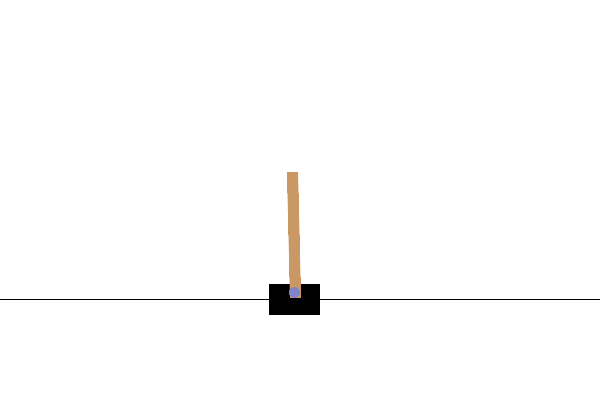

Episode 2000: Average reward over last 10 episodes = 122.8
Saved performance as cartpole_progress_ep2000.gif


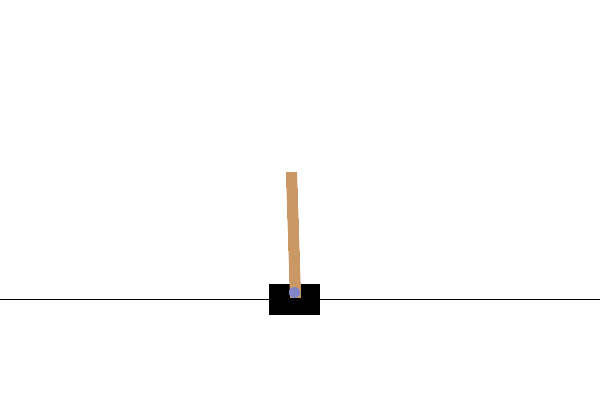

Episode 3000: Average reward over last 10 episodes = 136.7
Saved performance as cartpole_progress_ep3000.gif


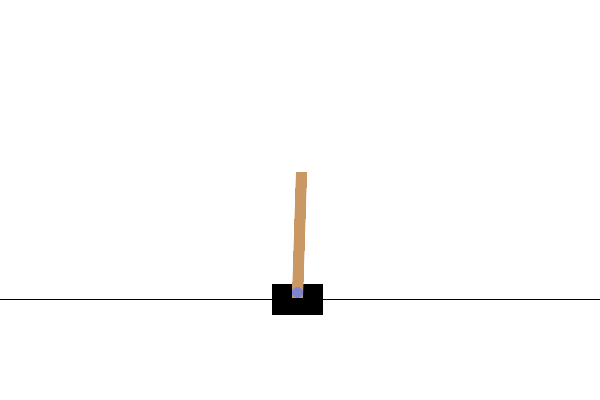

Episode 4000: Average reward over last 10 episodes = 183.5
Saved performance as cartpole_progress_ep4000.gif


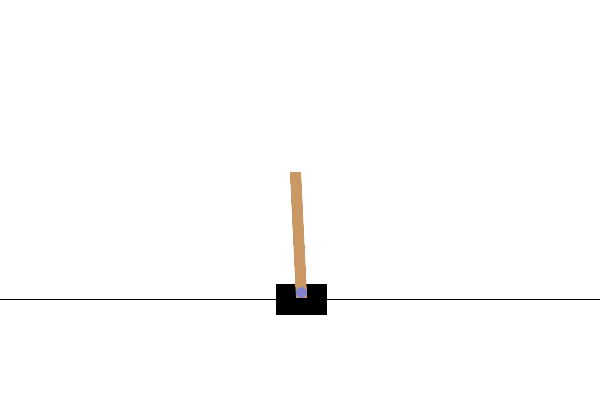

Episode 5000: Average reward over last 10 episodes = 151.3
Saved performance as cartpole_progress_ep5000.gif


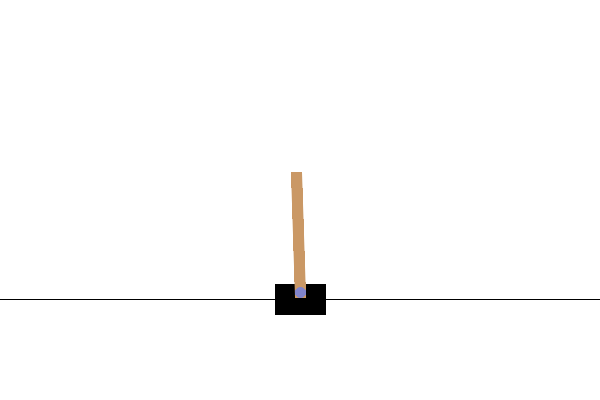

Episode 6000: Average reward over last 10 episodes = 137.1
Saved performance as cartpole_progress_ep6000.gif


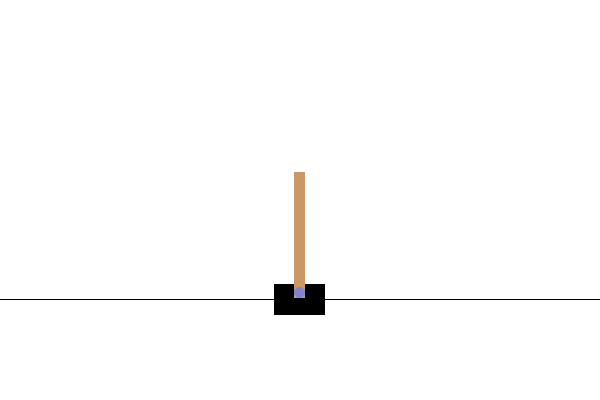

Episode 7000: Average reward over last 10 episodes = 128.4
Saved performance as cartpole_progress_ep7000.gif


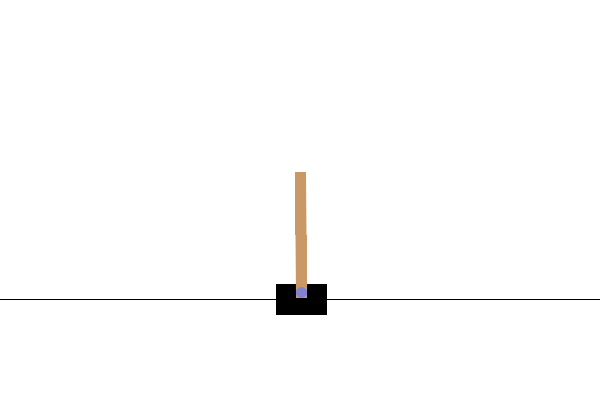

Episode 8000: Average reward over last 10 episodes = 149.2
Saved performance as cartpole_progress_ep8000.gif


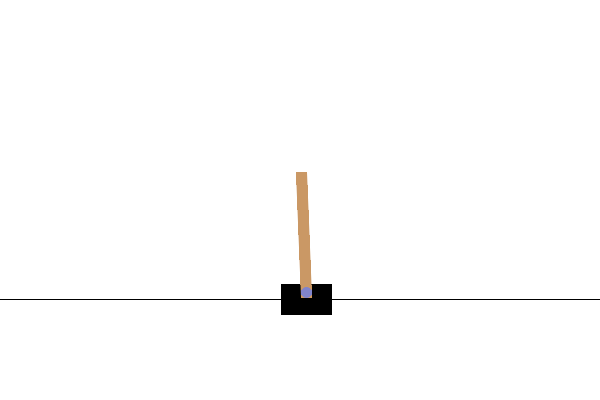

Episode 9000: Average reward over last 10 episodes = 236.0
Saved performance as cartpole_progress_ep9000.gif


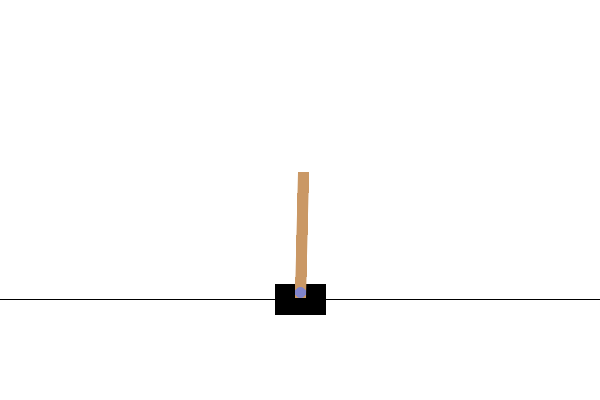

Episode 10000: Average reward over last 10 episodes = 153.5
Saved performance as cartpole_progress_ep10000.gif


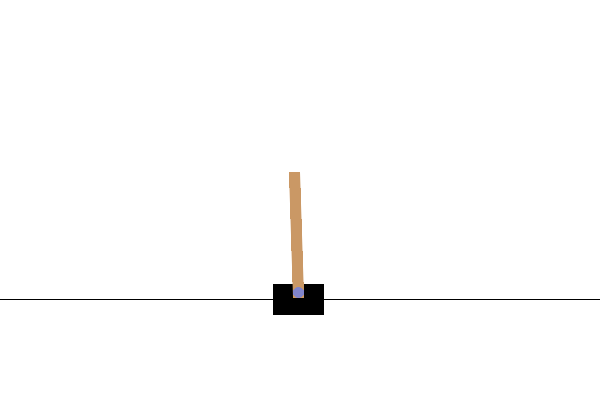

Saved performance as cartpole_bins_10.gif


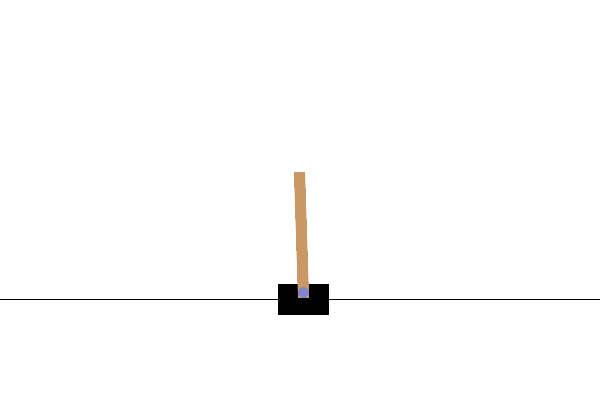

Average reward over 10 episodes: 447.9
Q-table size: 20000


In [ ]:
results = []
bins = 10
episodes = 8000 # can be any number (try 10000+ as well)
_, avg_reward, q_table_size = run_experiment(bins, max_steps=500, episodes=episodes)
results.append((bins, avg_reward, q_table_size))